# **📺 Anime Rating Prediction with Machine Learning**

## **Business Problem**
Most user generated ratings from streaming platforms are noisy, biased, and unreliable. Popularity spikes can inflate scores, and older, less-known titles have only a few votes. This inconsistencies hurt recommendation quality and content discovery for users. We aim to develop a more reliable and data-driven model to estimate expected audience score of animes. The insights can be used by platforms to improve their catalog management, content recommendations for users, and allocate marketing budget.

**Goal**: Accurately estimate an anime's audience score (1-10) to improve content ranking and user recommendation.

**Analytical approach**: Develop a machine learning model that predicts the expected audience rating of an anime using intrinsic (genre, type, duration, studio, etc) and engagement (favorites, member amounts, popularity, etc) attributes.

**Stakeholder**: Streaming platform product managers.

## **Objectives**
1. Develop a machine learning that predicts user score with high accuracy (RMSE < 0.5).
2. Provides feature insights into what drives audience perception.

## **Evaluation Metrics**
- **RMSE** (target < 0.5): Perfect for models that wants to achieve high accuracy.
- **R² score**: Captures proportion of variance and model stability.
- **MAPE**: Easily interpretable percentage metric for stakeholders.

## **Executive Summary**
- The developed model was able to successfully predict anime scores with high accuracy and performance **(RMSE 0.375, and MAPE 4.37%)**.
- Audience engagement metrics **(favorites, engagement ratio, and scored_by)** are the most influential indicators of how highly an anime is rated.
- Model can be used to **prioritize marketing budget** on possible hit titles to maximize return.

----

## **Data Dictionary**
Data used is the Top 15,000 Ranked Anime Dataset that was collected from MyAnimeList by Quanthan which can be found [here](https://www.kaggle.com/datasets/quanthan/top-15000-ranked-anime-dataset-update-to-32025). Each row represents a unique anime and they are ordered by their MyAnimeList rank.

| Column          | Description |
|-----------------|-------------|
| anime_id        | Unique identifier for the anime on MyAnimeList (MAL ID). |
| anime_url       | URL link to the anime's page on MyAnimeList. |
| image_url       | URL of the anime's main visual or cover image (JPEG format). |
| name            | Official title of the anime. |
| english_name    | Official English title of the anime, if available. |
| japanese_names  | Official Japanese title of the anime, if available. |
| score           | Average score/rating of the anime on MyAnimeList (1–10, higher is better). |
| genres          | Comma-separated list of genres associated with the anime (e.g., Action, Comedy, Fantasy). |
| themes          | Comma-separated list of themes associated with the anime (e.g., Psychological, Time Travel). |
| demographics    | Target audience of the anime (e.g., Shounen, Shoujo, Seinen, Josei). |
| synopsis        | Brief summary or plot description of the anime. |
| type            | Type of anime (e.g., TV, Movie, OVA, ONA, Special, Music). |
| episodes        | Number of episodes. |
| premiered       | Season and year the anime premiered (e.g., "Fall 2013"). |
| producers       | Comma-separated list of production companies involved. |
| studios         | Animation studios responsible for creating the anime. |
| source          | Original source material (e.g., Manga, Original, Light Novel, Game). |
| duration        | Duration of each episode in minutes. |
| rating          | Age/content rating (e.g., PG-13, R+, G). |
| rank            | MAL ranking based on score (lower is better). Dataset contains the top ~15k anime. |
| popularity      | Popularity rank on MAL (lower is more popular). |
| favorites       | Number of users who marked this anime as a favorite. |
| scored_by       | Number of users who rated the anime. |
| members         | Number of users listed as members of the anime’s MAL community. |

#### **Import Libraries and Data**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# split
from sklearn.model_selection import train_test_split

# binning
from sklearn.preprocessing import KBinsDiscretizer

# Polynomial
from sklearn.preprocessing import PolynomialFeatures

# column transformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Preprocessing
# imputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer,IterativeImputer, KNNImputer

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder
from category_encoders.binary import BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Cross Validation
from sklearn.model_selection import StratifiedKFold, KFold,cross_val_score, cross_validate

# model
from sklearn.tree import plot_tree, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
import statsmodels.api as sm
from sklearn.feature_selection import SelectFromModel

# Hyperparameter Tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import optuna

# scoring
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import cross_validate
from skrub.datasets import fetch_employee_salaries

#skrub auto eda
from skrub import TableReport

from sklearn.feature_selection import SelectKBest, f_regression

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    BaggingRegressor,
    RandomForestRegressor,
    AdaBoostRegressor,
    GradientBoostingRegressor
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import FunctionTransformer

import time

from sklearn.metrics import make_scorer, mean_absolute_percentage_error

#FEATURE IMPORTANCE
import shap

#LEARNING CURVE
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve

import pickle
import warnings
warnings.filterwarnings('ignore')
import re

In [ ]:
dir = r"PATH/TO/DIR"
df = pd.read_csv(dir)

df.head(10)

anime_id                                          anime_url  \
0     52991  https://myanimelist.net/anime/52991/Sousou_no_...   
1      5114  https://myanimelist.net/anime/5114/Fullmetal_A...   
2      9253     https://myanimelist.net/anime/9253/Steins_Gate   
3     38524  https://myanimelist.net/anime/38524/Shingeki_n...   
4     28977       https://myanimelist.net/anime/28977/Gintama°   
5     39486  https://myanimelist.net/anime/39486/Gintama__T...   
6     60022  https://myanimelist.net/anime/60022/One_Piece_...   
7     11061  https://myanimelist.net/anime/11061/Hunter_x_H...   
8      9969         https://myanimelist.net/anime/9969/Gintama   
9     15417  https://myanimelist.net/anime/15417/Gintama__E...   

                                           image_url  \
0  https://cdn.myanimelist.net/images/anime/1015/...   
1  https://cdn.myanimelist.net/images/anime/1208/...   
2  https://cdn.myanimelist.net/images/anime/1935/...   
3  https://cdn.myanimelist.net/images/anime/1517/...   
4  https://cdn.myanimelist.net/images/anime/3/720...   
5  https://cdn.myanimelist.net/images/anime/1245/...   
6  https://cdn.myanimelist.net/images/anime/1455/...   
7  https://cdn.myanimelist.net/images/anime/1337/...   
8  https://cdn.myanimelist.net/images/anime/4/503...   
9  https://cdn.myanimelist.net/images/anime/1452/...   

                                 name                      english_name  \
0                   Sousou no Frieren     Frieren: Beyond Journey's End   
1    Fullmetal Alchemist: Brotherhood  Fullmetal Alchemist: Brotherhood   
2                         Steins;Gate                       Steins;Gate   
3  Shingeki no Kyojin Season 3 Part 2   Attack on Titan Season 3 Part 2   
4                            Gintama°                  Gintama Season 4   
5                  Gintama: The Final           Gintama: The Very Final   
6                One Piece Fan Letter                               NaN   
7              Hunter x Hunter (2011)                   Hunter x Hunter   
8                            Gintama'                  Gintama Season 2   
9                 Gintama': Enchousen                Gintama: Enchousen   

               japanese_names  score                             genres  \
0                    葬送のフリーレン   9.29          Adventure, Drama, Fantasy   
1  鋼の錬金術師 FULLMETAL ALCHEMIST   9.10  Action, Adventure, Drama, Fantasy   
2                 STEINS;GATE   9.07            Drama, Sci-Fi, Suspense   
3        進撃の巨人 Season3 Part.2   9.05            Action, Drama, Suspense   
4                         銀魂°   9.05             Action, Comedy, Sci-Fi   
5                銀魂 THE FINAL   9.05      Action, Comedy, Drama, Sci-Fi   
6        ONE PIECE FAN LETTER   9.03         Action, Adventure, Fantasy   
7    HUNTER×HUNTER（ハンター×ハンター）   9.03         Action, Adventure, Fantasy   
8                         銀魂'   9.02             Action, Comedy, Sci-Fi   
9                     銀魂' 延長戦   9.02             Action, Comedy, Sci-Fi   

                                   themes demographics  ...  \
0                                     NaN      Shounen  ...   
1                                Military      Shounen  ...   
2              Psychological, Time Travel          NaN  ...   
3                Gore, Military, Survival      Shounen  ...   
4  Gag Humor, Historical, Parody, Samurai      Shounen  ...   
5  Gag Humor, Historical, Parody, Samurai      Shounen  ...   
6                                     NaN      Shounen  ...   
7                                     NaN      Shounen  ...   
8  Gag Humor, Historical, Parody, Samurai      Shounen  ...   
9  Gag Humor, Historical, Parody, Samurai      Shounen  ...   

                                           producers                studios  \
0  Aniplex, Dentsu, Shogakukan-Shueisha Productio...               Madhouse   
1  Aniplex, Square Enix, Mainichi Broadcasting Sy...                  Bones   
2  Frontier Works, Media Factory, Kadokawa Shoten...              White Fox 

### **Initial Exploratory Data Analysis (EDA)**

Figure out data types, their dimensions, and identify missing values & duplicates.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   anime_id        15000 non-null  int64  
 1   anime_url       15000 non-null  object 
 2   image_url       15000 non-null  object 
 3   name            15000 non-null  object 
 4   english_name    8748 non-null   object 
 5   japanese_names  14966 non-null  object 
 6   score           15000 non-null  float64
 7   genres          14382 non-null  object 
 8   themes          9166 non-null   object 
 9   demographics    4619 non-null   object 
 10  synopsis        14486 non-null  object 
 11  type            15000 non-null  object 
 12  episodes        14889 non-null  float64
 13  premiered       5012 non-null   object 
 14  producers       9930 non-null   object 
 15  studios         13246 non-null  object 
 16  source          15000 non-null  object 
 17  duration        15000 non-null 

In [4]:
TableReport(df)

Processing column  24 / 24


<TableReport: use .open() to display>

### **Initial Cleaning**

In [5]:
df.drop(columns=['anime_url', 'image_url', 'english_name', 'japanese_names', 'themes', 'demographics', 'synopsis', 'premiered', 'rank', 'producers'], inplace=True)

df

anime_id                                               name  score  \
0         52991                                  Sousou no Frieren   9.29   
1          5114                   Fullmetal Alchemist: Brotherhood   9.10   
2          9253                                        Steins;Gate   9.07   
3         38524                 Shingeki no Kyojin Season 3 Part 2   9.05   
4         28977                                           Gintama°   9.05   
...         ...                                                ...    ...   
14995     38354                               Ganbare! Memeko-chan   5.12   
14996     38506                                    Tokyo Art Month   5.12   
14997     30782                                    Bikini Warriors   5.12   
14998     35612  Himitsukessha Taka no Tsume x Glass no Kamen d...   5.12   
14999     35502                         Pure Aluminum: Sunoko-tan.   5.12   

                                  genres type  episodes  \
0              Adventure, Drama, Fantasy   TV      28.0   
1      Action, Adventure, Drama, Fantasy   TV      64.0   
2                Drama, Sci-Fi, Suspense   TV      24.0   
3                Action, Drama, Suspense   TV      10.0   
4                 Action, Comedy, Sci-Fi   TV      51.0   
...                                  ...  ...       ...   
14995              Comedy, Slice of Life  OVA       1.0   
14996                        Avant Garde  ONA       1.0   
14997             Comedy, Fantasy, Ecchi   TV      12.0   
14998                             Comedy  ONA       1.0   
14999                             Comedy  OVA       1.0   

                     studios        source       duration  \
0                   Madhouse         Manga  24 min per ep   
1                      Bones         Manga  24 min per ep   
2                  White Fox  Visual novel  24 min per ep   
3                 Wit Studio         Manga  23 min per ep   
4      Bandai Namco Pictures         Manga  24 min per ep   
...                      ...           ...            ...   
14995         Studio Moriken  4-koma manga          7 min   
14996        Saigo no Shudan      Original         47 sec   
14997             feel., PRA         Other   4 min per ep   
14998                    DLE         Other          2 min   
14999           Ishikawa Pro         Other          1 min   

                               rating  popularity  favorites  scored_by  \
0           PG-13 - Teens 13 or older         128      76513   734207.0   
1      R - 17+ (violence & profanity)           3     236798  2249670.0   
2           PG-13 - Teens 13 or older          14     198296  1483605.0   
3      R - 17+ (violence & profanity)          21      61832  1729484.0   
4           PG-13 - Teens 13 or older         344      17315   266825.0   
...                               ...         ...        ...        ...   
14995                    G - All Ages       17262          0      194.0   
14996                    G - All Ages       19011          0      161.0   
14997                R+ - Mild Nudity        2337        193    44467.0   
14998                    G - All Ages       17011          0      178.0   
14999                    G - All Ages       17458          0      198.0   

       members  
0      1225468  
1      3577489  
2      2737980  
3      2497671  
4       676352  
...        ...  
14995      552  
14996      403  
14997    98599  
14998      579  
14999      530  

[15000 rows x 14 columns]

In [6]:
TableReport(df)

Processing column  14 / 14


<TableReport: use .open() to display>

#### **Duplicate Treatment**

In [7]:
df[df.duplicated() == True]

anime_id                     name  score             genres type  \
1954     62352       Chainsaw Man Recap   7.52    Action, Fantasy  ONA   
2451     62419  Jebal Joyonghi Jom Hae!   7.40  Boys Love, Comedy  ONA   
5678     62286    Guimi Zhi Zhu: Caidan   6.81    Comedy, Fantasy  ONA   

      episodes          studios     source            duration  \
1954       2.0            MAPPA      Manga  1 hr 47 min per ep   
2451       5.0              NaN   Original        6 min per ep   
5678       9.0  B.CMAY PICTURES  Web novel        1 min per ep   

                              rating  popularity  favorites  scored_by  \
1954  R - 17+ (violence & profanity)        6781         17     1762.0   
2451       PG-13 - Teens 13 or older       14257         10      385.0   
5678                    G - All Ages       11007          9      802.0   

      members  
1954    10790  
2451     1145  
5678     2920

In [8]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

np.int64(0)

#### **Missing Values Identification**

In [9]:
df.isna().sum()

anime_id         0
name             0
score            0
genres         618
type             0
episodes       111
studios       1753
source           0
duration         0
rating          79
popularity       0
favorites        0
scored_by        0
members          0
dtype: int64

#### Genre

In [10]:
df[df["genres"].isna()== True]

anime_id                                               name  score  \
218       50183                                         Blue Giant   8.39   
242       39167                 Girls & Panzer: Saishuushou Part 4   8.36   
453       39166                 Girls & Panzer: Saishuushou Part 3   8.17   
575       38081                 Girls & Panzer: Saishuushou Part 2   8.08   
694       41781  BanG Dream! Movie: Episode of Roselia - II: So...   8.00   
...         ...                                                ...    ...   
14902     29925                                       Poron Guitar   5.17   
14923     23375                                       Minarai Diva   5.16   
14936     34423                                   Spring has come!   5.15   
14942     29918                            Go-hiki no Kozaru-tachi   5.15   
14972     36673                  Nakano Harada Kekkon Kyousoukyoku   5.13   

      genres     type  episodes    studios       source       duration  \
218      NaN    Movie       1.0        Nut        Manga    1 hr 59 min   
242      NaN    Movie       1.0      Actas     Original         54 min   
453      NaN    Movie       1.0      Actas     Original         48 min   
575      NaN    Movie       1.0      Actas     Original         54 min   
694      NaN    Movie       1.0   SANZIGEN  Mixed media    1 hr 10 min   
...      ...      ...       ...        ...          ...            ...   
14902    NaN    Movie       1.0        NaN      Unknown         26 min   
14923    NaN       TV      10.0  Yaoyorozu     Original  49 min per ep   
14936    NaN      ONA       1.0  Decovocal     Original         44 sec   
14942    NaN    Movie       1.0        NaN     Original         16 min   
14972    NaN  Special       1.0        NaN     Original          3 min   

                          rating  popularity  favorites  scored_by  members  
218    PG-13 - Teens 13 or older        3742        428    15658.0    43609  
242    PG-13 - Teens 13 or older        4935        120     7820.0    24022  
453    PG-13 - Teens 13 or older        3661        120    15271.0    45323  
575    PG-13 - Teens 13 or older        3756        112    21398.0    43264  
694    PG-13 - Teens 13 or older        6495         77     5271.0    11985  
...                          ...         ...        ...        ...      ...  
14902               G - All Ages       18988          0      157.0      405  
14923               G - All Ages       12070          4      336.0     2158  
14936               G - All Ages       18984          1      165.0      406  
14942               G - All Ages       17877          0      187.0      492  
14972               G - All Ages       20143          0      126.0      326  

[618 rows x 14 columns]

Less than 5% of the entire data, will simple impute with "Unknown"

#### Episodes

In [11]:
df[df["episodes"].isna()== True]

anime_id                       name  score  \
53           21                  One Piece   8.73   
160       60988  Tian Guan Cifu Short Film   8.47   
212       50250                   Chiikawa   8.39   
446         235            Meitantei Conan   8.18   
475       44042           Holo no Graffiti   8.15   
...         ...                        ...    ...   
14293     60147                     Ikusei   5.38   
14296     51870    Pokemon de Manabi Asobu   5.38   
14327     58641    Mugoku no Kuni no Alice   5.37   
14358     56154      Mahou Touki Lilustear   5.36   
14765     35694             Kirin the Noop   5.23   

                                  genres        type  episodes  \
53            Action, Adventure, Fantasy          TV       NaN   
160    Action, Adventure, Drama, Fantasy         ONA       NaN   
212                        Slice of Life          TV       NaN   
446           Adventure, Comedy, Mystery          TV       NaN   
475                               Comedy         ONA       NaN   
...                                  ...         ...       ...   
14293                             Hentai         OVA       NaN   
14296                             Comedy         ONA       NaN   
14327                             Hentai         OVA       NaN   
14358                             Hentai         OVA       NaN   
14765                          Adventure  TV Special       NaN   

                   studios        source duration                     rating  \
53          Toei Animation         Manga   24 min  PG-13 - Teens 13 or older   
160                    NaN     Web novel    8 min  PG-13 - Teens 13 or older   
212              Doga Kobo     Web manga    1 min               G - All Ages   
446      TMS Entertainment         Manga   24 min  PG-13 - Teens 13 or older   
475    Hololive Production         Other    1 min  PG-13 - Teens 13 or older   
...                    ...           ...      ...                        ...   
14293        Suzuki Mirano  Visual novel   15 min                Rx - Hentai   
14296                  NaN          Game    3 min              PG - Children   
14327                Majin          Game   15 min                Rx - Hentai   
14358                Majin          Game   20 min                Rx - Hentai   
14765                  NaN      Original    5 min               G - All Ages   

       popularity  favorites  scored_by  members  
53             17     243486  1469982.0  2582705  
160          7257        117     1828.0     9192  
212          6402        374     3558.0    12428  
446           707      15715   167262.0   370629  
475          3171       1880    18066.0    58289  
...           ...        ...        ...      ...  
14293       12079          7      612.0     2154  
14296       13736          1      403.0     1311  
14327       12675          6      510.0     1781  
14358       12024          4      542.0     2188  
14765       15394          1      152.0      845  

[111 rows x 14 columns]

Cant replace with mean or median. Cant be inferred from anywhere else. Less than 1% of the data. We will drop.

In [12]:
df = df[~df["episodes"].isna()== True]

#### Studios

In [13]:
df[df["studios"].isna()== True]

anime_id                                               name  score  \
554       58689                              Yuanshen: Jinzhong Ge   8.09   
753       59077      Benghuai: Xing Qiong Tiedao - Gelamo de Yujin   7.95   
912       58930                           Yuanshen: Weixing Zhi Lu   7.87   
1014       6505                                  Tteotda Keunyeo!!   7.83   
1299      61274                         Ginga Tokkyuu Milky☆Subway   7.71   
...         ...                                                ...    ...   
14982      6131                        Charady no Joke na Mainichi   5.13   
14984     17989  Super Real Mahjong: Mahjong Battle Scramble - ...   5.13   
14986     15455                                             Sakura   5.13   
14988     12865                                      Ai wa KAT-TUN   5.13   
14991      7343                          Youbi Masochist Animation   5.12   

                        genres   type  episodes studios    source  \
554     Action, Drama, Fantasy    ONA       1.0     NaN      Game   
753    Action, Fantasy, Sci-Fi    ONA       1.0     NaN      Game   
912             Drama, Fantasy    ONA       1.0     NaN      Game   
1014           Comedy, Romance    ONA       5.0     NaN  Original   
1299            Comedy, Sci-Fi     TV      12.0     NaN  Original   
...                        ...    ...       ...     ...       ...   
14982                   Comedy     TV     365.0     NaN  Original   
14984   Comedy, Fantasy, Ecchi    OVA       1.0     NaN      Game   
14986                  Fantasy  Movie       1.0     NaN  Original   
14988                   Comedy    ONA       5.0     NaN     Other   
14991                   Hentai    OVA       2.0     NaN   Unknown   

            duration                     rating  popularity  favorites  \
554            7 min  PG-13 - Teens 13 or older        8344         22   
753            6 min  PG-13 - Teens 13 or older       10950          8   
912            3 min               G - All Ages       10125         16   
1014    4 min per ep               G - All Ages        4803        152   
1299    3 min per ep  PG-13 - Teens 13 or older        7255         39   
...              ...                        ...         ...        ...   
14982   3 min per ep  PG-13 - Teens 13 or older       11142          3   
14984         45 min           R+ - Mild Nudity       13761          1   
14986          8 min               G - All Ages       13788          1   
14988  53 sec per ep               G - All Ages       11333          9   
14991  33 min per ep                Rx - Hentai       15045          4   

       scored_by  members  
554       3464.0     6496  
753       1433.0     2967  
912       1865.0     3818  
1014     14052.0    25643  
1299      2844.0     9196  
...          ...      ...  
14982      885.0     2806  
14984      554.0     1303  
14986      625.0     1293  
14988     1132.0     2661  
14991      301.0      933  

[1741 rows x 14 columns]

~10% of the entire data. will simple impute with "Unknown"

#### Rating

In [14]:
df[df["rating"].isna()== True]

anime_id                                  name  score  \
2164      45599          Xue Ying Ling Zhu 2nd Season   7.47   
2962       9200    Dae Jang Geum: Jang Geum's Dream 2   7.30   
2985      60567                         Chang Ge Xing   7.29   
3097      57422                  Cong Hong Yue Kaishi   7.27   
3883      60168       Watashi wo Tabetai, Hitodenashi   7.14   
...         ...                                   ...    ...   
14499     10967   Circuit no Ookami II: Modena no Ken   5.32   
14551      5018                               Piroppo   5.30   
14556     16778             Gold Pencil And Alien Boy   5.30   
14921     42055  Chou Futsuu Toshi Kashiwa Densetsu Z   5.16   
14963     16620                            Robot King   5.14   

                                       genres   type  episodes  \
2164      Action, Adventure, Fantasy, Romance    ONA      22.0   
2962               Adventure, Comedy, Gourmet     TV      26.0   
2985                 Action, Adventure, Drama    ONA      16.0   
3097   Horror, Sci-Fi, Supernatural, Suspense    ONA      16.0   
3883          Drama, Girls Love, Supernatural     TV      13.0   
...                                       ...    ...       ...   
14499                                     NaN    OVA       1.0   
14551                                  Comedy     TV      23.0   
14556                               Adventure  Movie       1.0   
14921                         Comedy, Fantasy    ONA      10.0   
14963                                  Action  Movie       1.0   

                   studios    source       duration rating  popularity  \
2164         Mili Pictures     Novel  18 min per ep    NaN       10997   
2962                   NaN     Other  24 min per ep    NaN       11554   
2985                   NaN     Manga  24 min per ep    NaN       14826   
3097             Foch Film     Novel  18 min per ep    NaN       13931   
3883          Studio Lings     Manga  23 min per ep    NaN        4416   
...                    ...       ...            ...    ...         ...   
14499               Gainax     Manga         44 min    NaN       13909   
14551           Studio 4°C     Other   2 min per ep    NaN       15041   
14556                  NaN   Unknown     1 hr 5 min    NaN       18136   
14921  Super Normal Studio  Original   3 min per ep    NaN       15325   
14963                  NaN   Unknown     1 hr 5 min    NaN       18339   

       favorites  scored_by  members  
2164           9     1285.0     2925  
2962          14      994.0     2493  
2985           7      150.0      987  
3097           7      291.0     1246  
3883         122      232.0    30784  
...          ...        ...      ...  
14499          0      485.0     1257  
14551          2      197.0      934  
14556          0      128.0      469  
14921          0      196.0      862  
14963          0      152.0      454  

[78 rows x 14 columns]

Will try to drop animes with missing studios and rating.

In [15]:
df[(df["rating"].isna() == True) & (df["studios"].isna() == True)]

anime_id                                              name  score  \
2962       9200                Dae Jang Geum: Jang Geum's Dream 2   7.30   
2985      60567                                     Chang Ge Xing   7.29   
5042      36537                              Starmyu in Halloween   6.92   
8532       8999                                  Origami Warriors   6.40   
9357       7751                            Midnight Horror School   6.28   
9430      45600                                 Chang An Huan Jie   6.27   
9759      16530                               Ojamanga Yamada-kun   6.22   
10132      9424                              Seupideuwang Beongae   6.17   
10250     16027              Greek Roman Sinhwa: Olympus Guardian   6.15   
10354      9345  Gakkou no Kowai Uwasa Shin: Hanako-san ga Kita!!   6.13   
10744     36429                                 Zhen Gyi Hong Shi   6.07   
10779     11245                                    Manga Nihonshi   6.07   
11026     16730                       Ojamanga Yamada-kun (Movie)   6.03   
11859      9282          Duel Masters Movie 3: Honoo no Kizuna XX   5.89   
11879      9464     Ganbare Goemon: Chikyuu Kyuushutsu Daisakusen   5.89   
11975     16798                               Ttori wa Zeta Robot   5.87   
12128      8862                Ganbare Goemon: Jigen Jou no Akumu   5.84   
13579      9500                 Starlight Scramble Renai Kouhosei   5.57   
14164     16806                                   Super Titans 15   5.42   
14354     16257                   Efficus: Kono Omoi o Kimi ni...   5.37   
14556     16778                         Gold Pencil And Alien Boy   5.30   
14963     16620                                        Robot King   5.14   

                             genres   type  episodes studios        source  \
2962     Adventure, Comedy, Gourmet     TV      26.0     NaN         Other   
2985       Action, Adventure, Drama    ONA      16.0     NaN         Manga   
5042                  Slice of Life    OVA       1.0     NaN      Original   
8532              Action, Adventure     TV      52.0     NaN       Unknown   
9357                         Comedy     TV      52.0     NaN       Unknown   
9430                        Fantasy    ONA      40.0     NaN       Unknown   
9759          Comedy, Slice of Life     TV     103.0     NaN       Unknown   
10132                        Sports     TV      26.0     NaN   Light novel   
10250            Adventure, Fantasy     TV      39.0     NaN         Other   
10354  Comedy, Horror, Supernatural     TV      33.0     NaN       Unknown   
10744     Action, Adventure, Sci-Fi     TV      52.0     NaN       Unknown   
10779                           NaN     TV      52.0     NaN       Unknown   
11026         Comedy, Slice of Life  Movie       1.0     NaN       Unknown   
11859                       Fantasy  Movie       1.0     NaN      Original   
11879                        Comedy    OVA       1.0     NaN          Game   
11975             Action, Adventure  Movie       1.0     NaN       Unknown   
12128                        Comedy    OVA       1.0     NaN          Game   
13579       Action, Romance, Sci-Fi    OVA       2.0     NaN          Game   
14164                        Action  Movie       1.0     NaN       Unknown   
14354                           NaN    OVA       2.0     NaN  Visual novel   
14556                     Adventure  Movie       1.0     NaN       Unknown   
14963                        Action  Movie       1.0     NaN       Unknown   

            duration rating  popularity  favorites  scored_by  members  
2962   24 min per ep    NaN       11554         14      994.0     2493  
2985   24 min per ep    NaN       14826          7      150.0      987  
5042          26 min    NaN       10093         14      871.0     3859  
8532   30 min per ep    NaN       16789          4      191.0      606  
9357   12 min per ep    NaN       14752          4      151.0     1007  
9430   13 min per ep    N

In [16]:
df = df[~((df["rating"].isna() == True) & (df["studios"].isna() == True))]

In [17]:
df[df["rating"].isna()== True]

anime_id                                               name  score  \
2164      45599                       Xue Ying Ling Zhu 2nd Season   7.47   
3097      57422                               Cong Hong Yue Kaishi   7.27   
3883      60168                    Watashi wo Tabetai, Hitodenashi   7.14   
4814      40885                       Can Ci Pin: Fangzhu Xingkong   6.97   
5392      54945                                Chang An San Wan Li   6.86   
6233      11307                                    Ginga Patrol PJ   6.73   
7725       8415                                         Oi! Ryouma   6.51   
7740       4800                        Huckleberry Finn Monogatari   6.51   
7880       9383                   Chie-chan Funsenki: Jarinko Chie   6.49   
8190      17893                               Cheonbangjichuk Hani   6.45   
8240       3355                                       Fortune Dogs   6.44   
8241       9061                                 RPG Densetsu Hepoi   6.44   
8298      50445                                             San Ti   6.43   
8315      42291                                Xian Feng Jianyu Lu   6.43   
8799      17493        Ashita Genki ni Nare!: Hanbun no Satsumaimo   6.36   
9154      12483                Gregory Horror Show: The Last Train   6.31   
9280       8436                               Animentary: Ketsudan   6.29   
9320      60577                           Tong Ling Fei 2nd Season   6.28   
9339      38021           Monster Strike the Movie: Sora no Kanata   6.28   
9420       8786                                   Inakappe Taishou   6.27   
9439      17669                         Kunimatsu-sama no Otoridai   6.27   
9450      10335      Konpeki no Kantai: Sourai Kaihatsu Monogatari   6.27   
9548      42317                                     Cosmos Trailer   6.25   
9620       8141  Konchuu Monogatari Mitsubachi Hutch: Yuuki no ...   6.24   
9857      36197   Infini-T Force Movie: Gatchaman - Saraba Tomo yo   6.20   
10112     17687                    Bemubemu Hunter Kotengu Tenmaru   6.17   
10170     20127                                        Kariage-kun   6.16   
10173     19831                                    Ore wa Chokkaku   6.16   
10294     42657          Himitsukessha Taka no Tsume: Golden Spell   6.14   
10300      6271                   Gendai Kibunroku Kaii Monogatari   6.14   
10565      3870                                        Kick no Oni   6.10   
10812     33764                                 Ying Xiong Bie Nao   6.06   
11136     20223                            Shounen Tokugawa Ieyasu   6.01   
11491     19063                                 Judo-bu Monogatari   5.95   
11569     10820                   Sengoku Majin Goushougun (Movie)   5.94   
11612      8184                                 Bouken Gabotenjima   5.93   
11684      6272                                     Zakuro Yashiki   5.92   
11744      7960                                Pachislo Kizoku Gin   5.91   
11813     19505                                       Kaizoku Ouji   5.90   
11901     12887                                Uchuu Shounen Soran   5.88   
11932     13307                     Shounen Ninja Kaze no Fujimaru   5.88   
12043      2822                                       Bamboo Bears   5.86   
12290     15407                           Magical Suite Prism Nana   5.82   
12362     10889                                     Jungle Kurobee   5.81   
12697     33388                            Charanpo Land no Bouken   5.74   
12709      6630                   Asari-chan: Ai no Marchen Shoujo   5.74   
12810      9387                        Ginga Hyouryuu Vifam Recaps   5.72   
13393      8494                  Kikansha Yaemon: D51 no Daibouken   5.61   
13467     36440                                  Ku Pao Ying Xiong   5.59   
13488     20117                                     Kotowaza House   5.59   
13598      8883            Kikou Heidan J-Phoenix: PF Lips Shoutai   5.56   
136

Remaining 58 rows will be dropped.

In [18]:
df = df[~df["rating"].isna()== True]

In [19]:
df.isna().sum()

anime_id         0
name             0
score            0
genres         608
type             0
episodes         0
studios       1719
source           0
duration         0
rating           0
popularity       0
favorites        0
scored_by        0
members          0
dtype: int64

Genres and studios will be imputed with "Unknown"

#### Duration
Convert Duration into Integers in minutes

In [20]:
def convert_duration_to_minutes(duration_str):
    if pd.isna(duration_str):
        return np.nan

    duration_str = duration_str.lower()
    
    hr_match = re.search(r'(\d+)\s*hr', duration_str)
    min_match = re.search(r'(\d+)\s*min', duration_str)
    sec_match = re.search(r'(\d+)\s*sec', duration_str)

    hours = int(hr_match.group(1)) if hr_match else 0
    minutes = int(min_match.group(1)) if min_match else 0
    seconds = int(sec_match.group(1)) if sec_match else 0

    total_minutes = hours * 60 + minutes + seconds / 60.0

    return total_minutes if total_minutes > 0 else np.nan


df['duration_minutes'] = df['duration'].apply(convert_duration_to_minutes)

In [21]:
df[df["duration_minutes"].isna()== True]

anime_id                                               name  score  \
4179      59710    Inazuma Eleven: Aratanaru Eiyuu-tachi no Joshou   7.09   
6088      48273                                       Psychic Hero   6.75   
7156      39362  Astro Boy: Tetsuwan Atom - Getsumen Kichi - Ki...   6.59   
7333      59709     Inazuma Eleven: Soushuuhen Densetsu no Kickoff   6.56   
8386      30481                 Ginga Tetsudou 999 for Planetarium   6.42   
9073      23943         Kidou Senshi Gundam UC: One of Seventy Two   6.32   
10944     35018  Osomatsu-san: Haru no Zenkoku Dai Senbatsu Jou...   6.04   
11095     10756                                  Shita-kiri Suzume   6.02   
11839     38087                    Osomatsu-san: Hajimaru Hajimari   5.89   
12106     10759                                           Kintarou   5.85   
12597     22511                                           Kobutori   5.76   
13738     10758                                          Momotarou   5.53   
13758     30973                              Urashima Tarou (1952)   5.52   

                         genres     type  episodes         studios    source  \
4179                     Sports    Movie       1.0           MAPPA      Game   
6088                        NaN       TV      24.0             NaN   Unknown   
7156                     Sci-Fi    Movie       1.0             NaN     Manga   
7333                     Sports    Movie       1.0             OLM      Game   
8386   Adventure, Drama, Sci-Fi    Movie       1.0  Toei Animation   Unknown   
9073                        NaN  Special       1.0         Sunrise     Novel   
10944                    Comedy    Movie       1.0  Studio Pierrot     Manga   
11095                     Drama    Movie       1.0             NaN  Original   
11839           Comedy, Fantasy  Special       6.0  Studio Pierrot     Manga   
12106                     Drama    Movie       1.0             NaN  Original   
12597                    Comedy    Movie       1.0             NaN     Other   
13738                     Drama    Movie       1.0             NaN  Original   
13758                       NaN    Movie       1.0             NaN     Other   

      duration                          rating  popularity  favorites  \
4179   Unknown                    G - All Ages       12129          8   
6088   Unknown                   PG - Children       18541          2   
7156   Unknown                    G - All Ages       13110          0   
7333   Unknown                    G - All Ages       12545          7   
8386   Unknown                    G - All Ages       13610          1   
9073   Unknown       PG-13 - Teens 13 or older       10977          1   
10944  Unknown  R - 17+ (violence & profanity)       12717          2   
11095  Unknown                    G - All Ages       16061          1   
11839  Unknown       PG-13 - Teens 13 or older       13951          1   
12106  Unknown                    G - All Ages       16179          1   
12597  Unknown                    G - All Ages       15878          0   
13738  Unknown                    G - All Ages       15443          0   
13758  Unknown                    G - All Ages       18403          0   

       scored_by  members  duration_minutes  
4179       374.0     2121               NaN  
6088       171.0      439               NaN  
7156       497.0     1560               NaN  
7333       228.0     1865               NaN  
8386       210.0     1361               NaN  
9073       528.0     2947               NaN  
10944      276.0     1758               NaN  
11095      124.0      712               NaN  
11839      132.0     1243               NaN  
12106      145.0      692               NaN  
12597      160.0      742               NaN  
13738      192.0      836               NaN  
13758      106.0      449               NaN

We will drop all unknown duration.

In [22]:
df = df[df["duration"] != "Unknown"]

In [23]:
df.isna().sum()

anime_id               0
name                   0
score                  0
genres               605
type                   0
episodes               0
studios             1712
source                 0
duration               0
rating                 0
popularity             0
favorites              0
scored_by              0
members                0
duration_minutes       0
dtype: int64

#### Studios
Studio will only include the first value.

In [24]:
def get_first_studio(x):
    if pd.isna(x):
        return "Unknown" #missing value imputed with "unknown"
    s = str(x)
    first = re.split(r'[;,]', s)[0].strip()
    return first if first != "" and first.lower() != "nan" else "Unknown"

df['main_studio'] = df['studios'].apply(get_first_studio)

### **EDA**

Create a new df without anime_id to visualize for eda

In [25]:
df_scores = df.drop(columns=['anime_id'])

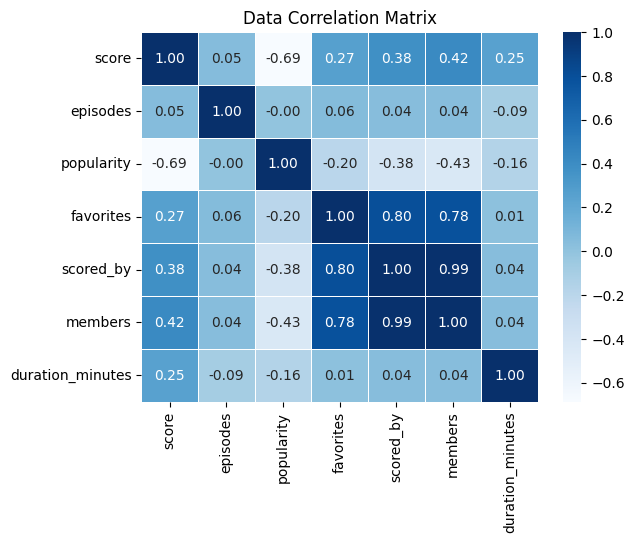

In [26]:
#CORRELATION MATRIX
corr_matrix = df_scores.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=.5)
plt.title("Data Correlation Matrix")
plt.show()

From numerical data score is most affected by:
- popularity (strong negative correlation, lower value is better)
- members
- scored_by
- favorites

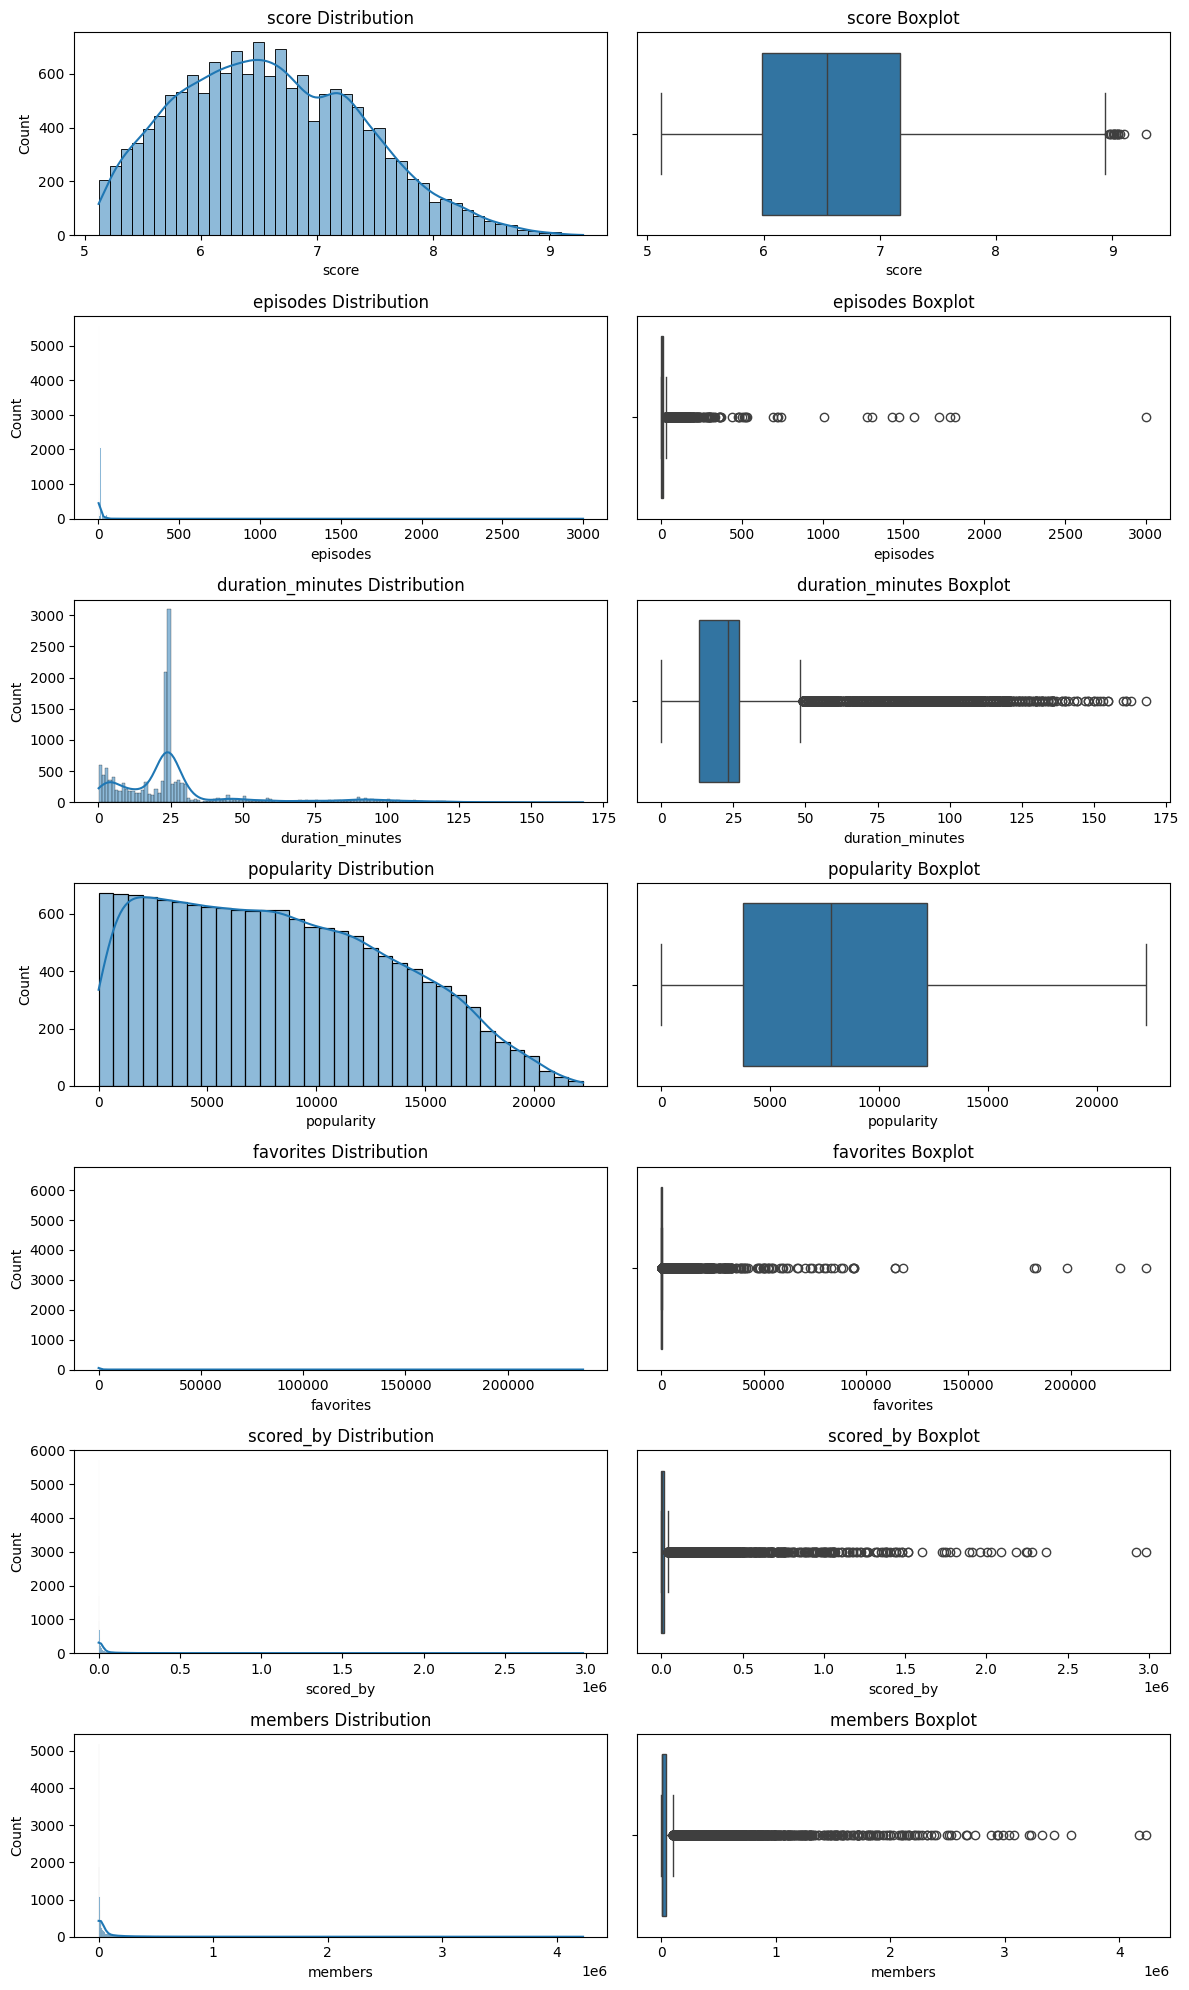

In [27]:
cols = ["score", "episodes", "duration_minutes", "popularity", "favorites", "scored_by", "members"]

fig, axes = plt.subplots(7, 2, figsize=(12, 20))

for i, col in enumerate(cols):
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"{col} Distribution")

    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} Boxplot")

plt.tight_layout()
plt.show()

### **Feature Engineering**

#### Create log-transformed Favorites, Scored by, Members
Because they are extremely skewed, create log-transformed versions of these columns.

In [28]:
df['log_favorites'] = np.log1p(df['favorites'])
df['log_scored_by'] = np.log1p(df['scored_by'])
df['log_members'] = np.log1p(df['members'])

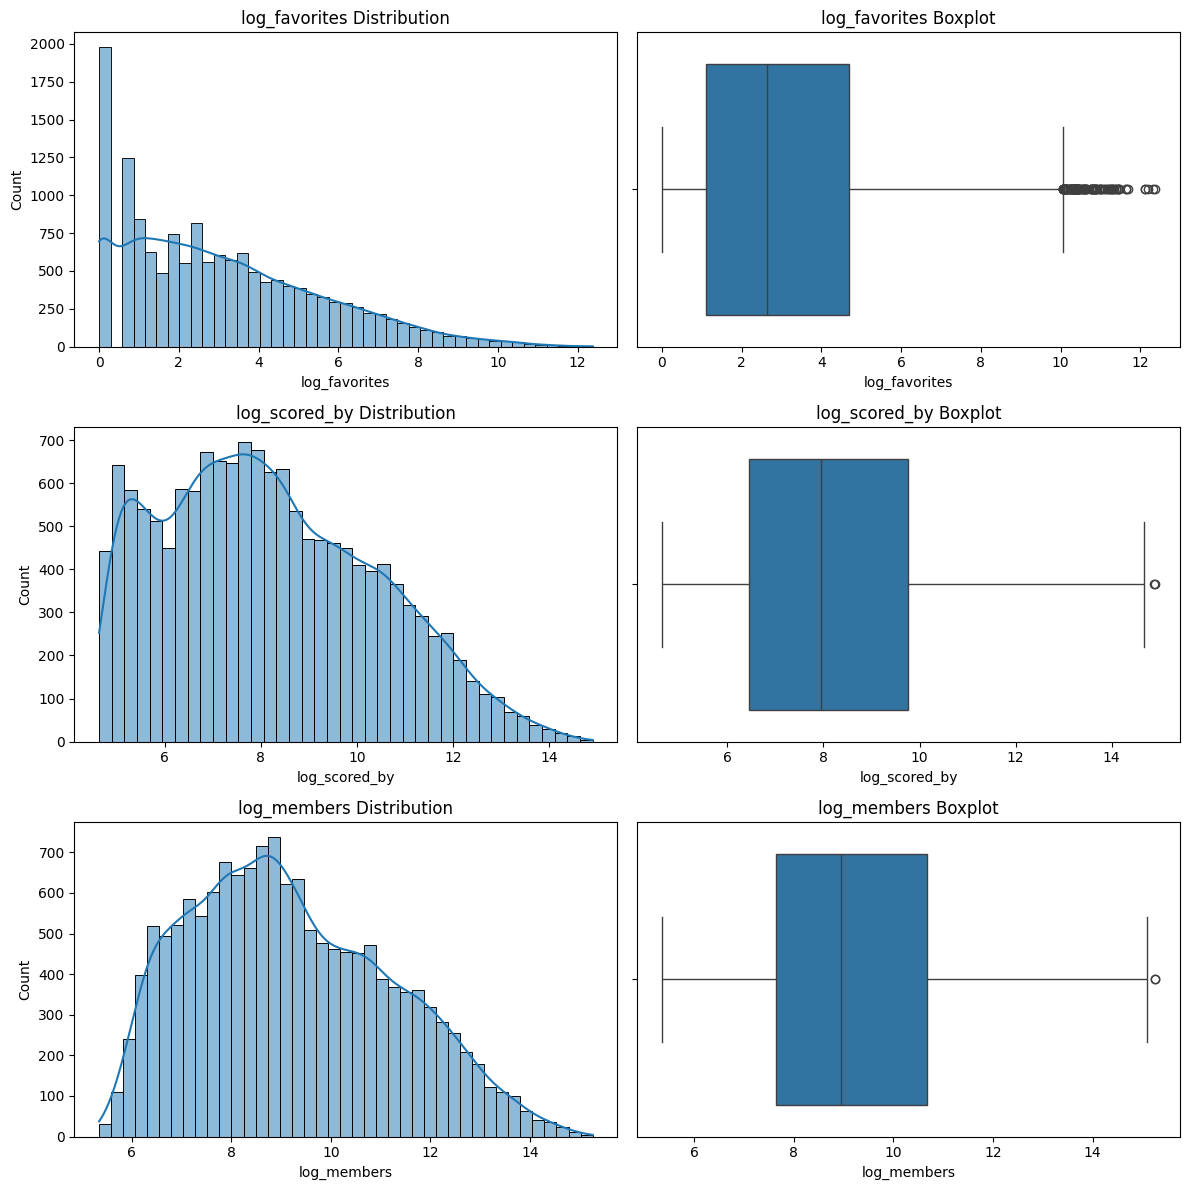

In [29]:
cols = ["log_favorites", "log_scored_by", "log_members"]

fig, axes = plt.subplots(3, 2, figsize=(12, 12))

for i, col in enumerate(cols):
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"{col} Distribution")

    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} Boxplot")

plt.tight_layout()
plt.show()

#### Create feature ratios

Better for the model to learn with

In [30]:
df['engagement_ratio'] = df['favorites'] / df['members'] #out of everyone who added the anime to their list, how many FAVORITED it?
df['score_density'] = df['scored_by'] / df['members'] #out of everyone who added the anime to their list, how many rated it?

df.replace([np.inf, -np.inf], 0, inplace=True)

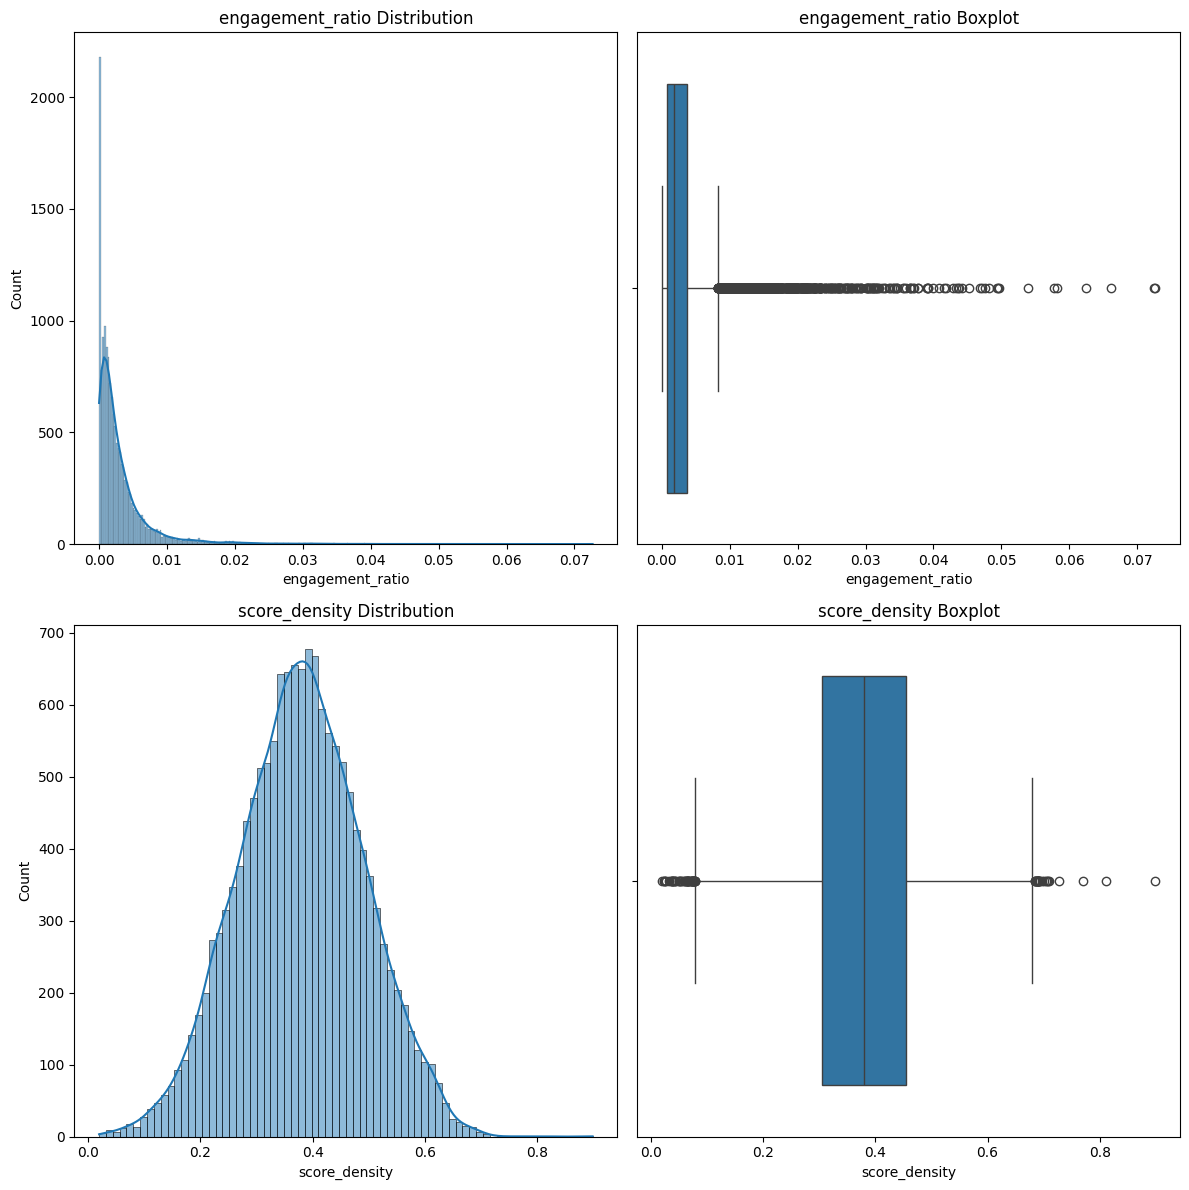

In [31]:
cols = ["engagement_ratio", "score_density"]

fig, axes = plt.subplots(2, 2, figsize=(12, 12))

for i, col in enumerate(cols):
    sns.histplot(df[col], kde=True, ax=axes[i, 0])
    axes[i, 0].set_title(f"{col} Distribution")

    sns.boxplot(x=df[col], ax=axes[i, 1])
    axes[i, 1].set_title(f"{col} Boxplot")

plt.tight_layout()
plt.show()

#### Create popularity scale
popularity lower value = more popular. transform into popularity inversed.

In [32]:
df['popularity_inverse'] = 1 / df['popularity']

#### Drop all transformed original features
Except popularity because rank and its inverse represent a different mathematical structure.

In [33]:
df.drop(['studios', 'favorites', 'scored_by', 'members', 'duration'], axis=1, inplace=True)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14795 entries, 0 to 14999
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   anime_id            14795 non-null  int64  
 1   name                14795 non-null  object 
 2   score               14795 non-null  float64
 3   genres              14190 non-null  object 
 4   type                14795 non-null  object 
 5   episodes            14795 non-null  float64
 6   source              14795 non-null  object 
 7   rating              14795 non-null  object 
 8   popularity          14795 non-null  int64  
 9   duration_minutes    14795 non-null  float64
 10  main_studio         14795 non-null  object 
 11  log_favorites       14795 non-null  float64
 12  log_scored_by       14795 non-null  float64
 13  log_members         14795 non-null  float64
 14  engagement_ratio    14795 non-null  float64
 15  score_density       14795 non-null  float64
 16  popularit

In [35]:
TableReport(df)

Processing column  17 / 17


<TableReport: use .open() to display>

### **Test/Train Split**

In [36]:
X = df.drop(columns=["score", "anime_id", "name"])
y = df["score"]    

In [37]:
num_cols = [
    "episodes",
    "popularity",
    "popularity_inverse",
    "log_favorites",
    "log_scored_by",
    "log_members",
    "engagement_ratio",
    "score_density",
    "duration_minutes",
]

cat_cols = [
    "type",
    "source",
    "rating",
    "main_studio",
]


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [39]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer

class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        # X is a DataFrame column → convert each row into list of labels
        cleaned = X.iloc[:, 0].fillna("").apply(lambda x: [i.strip() for i in x.split(",")])
        self.mlb.fit(cleaned)
        return self

    def transform(self, X):
        cleaned = X.iloc[:, 0].fillna("").apply(lambda x: [i.strip() for i in x.split(",")])
        return self.mlb.transform(cleaned)

### **Column Transformer**

- All numerical feature have a lot outliers = we will use robust scaling
- All Categorical columns have > 5 unique values = we will use binary encoder
- genre will use multiple binary columns

In [40]:
from category_encoders.binary import BinaryEncoder

#NUMERIC COLUMNS
numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())
])

#CATEGORICAL COLUMNS
categorical_transformer = Pipeline(steps=[
    ('binary', BinaryEncoder())
])

#FOR GENRE
genre_transformer = Pipeline(steps=[
    ('mlb', MultiLabelBinarizerTransformer())
])

In [ ]:
#PREPROCESSOR NO SCALING
preprocessor_noscal = ColumnTransformer(
	transformers=[
		('num', 'passthrough', num_cols),
		('cat', categorical_transformer, cat_cols),
        ('genre', genre_transformer, ['genres'])
	], remainder='drop'
)

In [ ]:
#PREPROCESSOR SCALED
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols),
        ('genre', genre_transformer, ['genres'])
    ], remainder='drop'
)

In [43]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', RobustScaler())]),
                                 ['episodes', 'popularity',
                                  'popularity_inverse', 'log_favorites',
                                  'log_scored_by', 'log_members',
                                  'engagement_ratio', 'score_density',
                                  'duration_minutes']),
                                ('cat',
                                 Pipeline(steps=[('binary', BinaryEncoder())]),
                                 ['type', 'source', 'rating', 'main_studio']),
                                ('genre',
                                 Pipeline(steps=[('mlb',
                                                  MultiLabelBinarizerTransformer())]),
                                 ['genres'])])

In [44]:
preprocessor_noscal

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['episodes', 'popularity',
                                  'popularity_inverse', 'log_favorites',
                                  'log_scored_by', 'log_members',
                                  'engagement_ratio', 'score_density',
                                  'duration_minutes']),
                                ('cat',
                                 Pipeline(steps=[('binary', BinaryEncoder())]),
                                 ['type', 'source', 'rating', 'main_studio']),
                                ('genre',
                                 Pipeline(steps=[('mlb',
                                                  MultiLabelBinarizerTransformer())]),
                                 ['genres'])])

In [45]:
X_train_prep_scal = preprocessor.fit_transform(X_train)
X_train_prep_scal

array([[ 0.27272727,  0.15169542, -0.10030667, ...,  0.        ,
         0.        ,  0.        ],
       [-0.18181818,  0.54467579, -0.26392889, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.45454545, -0.38726948,  0.51221055, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.90909091, -0.47091017,  0.73727698, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.81818182, -0.90184414, 26.4812752 , ...,  1.        ,
         0.        ,  0.        ],
       [-0.18181818,  0.1671624 , -0.10897026, ...,  0.        ,
         0.        ,  0.        ]])

In [46]:
X_train_prep = preprocessor_noscal.fit_transform(X_train)
X_train_prep

array([[6.00000000e+00, 9.05900000e+03, 1.10387460e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.23620000e+04, 8.08930594e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.00000000e+00, 4.52900000e+03, 2.20799293e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [1.30000000e+01, 3.82600000e+03, 2.61369577e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.20000000e+01, 2.04000000e+02, 4.90196078e-03, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 9.18900000e+03, 1.08825770e-04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

### **Model Benchmarking**

In [48]:
def ttr(model):
    return TransformedTargetRegressor(
        regressor=model,
        func=np.log1p,
        inverse_func=np.expm1
    )

### **Model Pipeline**

In [51]:
pipeLin = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ttr(LinearRegression()))
])

pipeKN = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ttr(KNeighborsRegressor()))
])

pipeRidge = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ttr(Ridge(alpha=1.0, random_state=42)))
])

pipeLasso = Pipeline([
    ('preprocessor', preprocessor),
    ('model', ttr(Lasso(alpha=0.001, random_state=42)))
])

pipeTree = Pipeline([
    ('preprocessor', preprocessor_noscal),
    ('model', ttr(DecisionTreeRegressor(random_state=42)))
])

pipeRf = Pipeline([
    ('preprocessor', preprocessor_noscal),
    ('model', ttr(RandomForestRegressor(random_state=42, n_jobs=-1)))
])

pipeAda = Pipeline([
    ('preprocessor', preprocessor_noscal), 
    ('model', ttr(AdaBoostRegressor(random_state=42)))
])

pipeLgm = Pipeline([
    ('preprocessor', preprocessor_noscal), 
    ('model', ttr(LGBMRegressor(random_state=42, n_estimators=500, objective='regression', verbose=-1)))
])

pipeXgb = Pipeline([
    ('preprocessor', preprocessor_noscal), 
    ('model', ttr(XGBRegressor(use_label_encoder=False, eval_metric='rmse', random_state=42)))
])

pipegrad = Pipeline([
    ('preprocessor', preprocessor_noscal),
    ('model', ttr(GradientBoostingRegressor(random_state=42)))
])

pipebag = Pipeline([
    ('preprocessor', preprocessor_noscal),
    ('model', ttr(BaggingRegressor(random_state=42)))
])

### **Cross Validation**

In [53]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
scorer = {
    'rmse': 'neg_root_mean_squared_error',
    'r2': 'r2',
    'mape': mape_scorer
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [54]:
list_model = [
    pipeLin,
    pipeRidge,
    pipeLasso,
    pipeKN,
    pipeTree,
    pipeRf,
    pipeAda,
    pipegrad,
    pipebag,
    pipeLgm,
    pipeXgb
]

In [55]:
rmseMeans = []
r2Means = []
mapeMeans = []
times = []
fittimes = []

for model in list_model:
    start = time.time()
    
    cv = cross_validate(
        estimator=model,
        X=X_train,
        y=y_train,
        scoring=scorer,
        cv=kf,
        n_jobs=-1,
        return_train_score=False
    )
    
    end = time.time()

    rmseMeans.append(-cv['test_rmse'].mean())
    r2Means.append(cv['test_r2'].mean())
    mapeMeans.append(-cv['test_mape'].mean())
    times.append(end - start)
    fittimes.append(cv['fit_time'].mean())

### **Best Model**

In [56]:
df_cv = pd.DataFrame({
    'Model': [m.named_steps['model'].regressor.__class__.__name__ for m in list_model],
    'Mean RMSE': rmseMeans,
    'Mean R²': r2Means,
    'Mean MAPE': mapeMeans,
    'Time' : times,
    'Fit Time' : fittimes
}).sort_values(by=['Mean RMSE'], ascending=[True]).reset_index(drop=True)
df_cv

Model  Mean RMSE   Mean R²  Mean MAPE      Time  \
0               LGBMRegressor   0.390334  0.751722   0.046294  3.056776   
1                XGBRegressor   0.405095  0.732620   0.048014  2.314717   
2       RandomForestRegressor   0.408032  0.728686   0.048150  4.232307   
3   GradientBoostingRegressor   0.425362  0.705171   0.050990  2.537376   
4            BaggingRegressor   0.429222  0.699727   0.050826  0.879245   
5         KNeighborsRegressor   0.441224  0.682731   0.052057  2.068524   
6            LinearRegression   0.451749  0.667446   0.054824  3.165599   
7                       Ridge   0.451806  0.667362   0.054834  2.277804   
8                       Lasso   0.478607  0.626724   0.057830  2.552428   
9           AdaBoostRegressor   0.515929  0.566402   0.062931  1.410189   
10      DecisionTreeRegressor   0.582756  0.446722   0.067695  0.283167   

    Fit Time  
0   2.742570  
1   2.228794  
2   3.001635  
3   2.457424  
4   0.818155  
5   0.062134  
6   0.427101  
7   0.122165  
8   0.089695  
9   1.241457  
10  0.193692

##### **Best performing model overall is Light Gradient Boosting.**

### **Hyperparameter Tuning**

In [57]:
pipeLgm.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['episodes', 'popularity',
                                                   'popularity_inverse',
                                                   'log_favorites',
                                                   'log_scored_by',
                                                   'log_members',
                                                   'engagement_ratio',
                                                   'score_density',
                                                   'duration_minutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('binary',
                                                                   BinaryEncoder())]),
                                                  ['type', 'source', 'rating',
                                                   'main_studio']),
                                                 ('genre',
                                                  Pipeline(steps=[('mlb',
                                                                   MultiLabelBinarizerTransformer())]),
                                                  ['genres'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LGBMRegressor(n_estimators=500,
                                                                    objective='regression',
                                                                    random_state=42,
                                                                    verbose=-1)))])

In [ ]:
#SET PARAMETERS
paramLgm = {
    'model__regressor__num_leaves': [31, 50, 100],
    'model__regressor__max_depth': [5, 10, 15],
    'model__regressor__learning_rate': [0.01, 0.05, 0.1],
    'model__regressor__n_estimators': [200, 500, 800],
    'model__regressor__min_child_samples': [10, 20, 30],
    'model__regressor__subsample': [0.7, 0.8, 1.0],
    'model__regressor__colsample_bytree': [0.7, 0.8, 1.0],
    'model__regressor__reg_alpha': [0, 0.1, 0.5],
    'model__regressor__reg_lambda': [0, 0.1, 0.5],
    'model__regressor__boosting_type': ['gbdt', 'dart']
}

In [ ]:
#USER RANDOMSEARCHCV
randomsearchLgbm = RandomizedSearchCV(
    estimator=pipeLgm,
    param_distributions=paramLgm,
    n_iter=50,
    cv=kf,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=42
)
randomsearchLgbm

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               'passthrough',
                                                                               ['episodes',
                                                                                'popularity',
                                                                                'popularity_inverse',
                                                                                'log_favorites',
                                                                                'log_scored_by',
                                                                                'log_members',
                                                                                'engagement_ratio',
                                                                                'score_density',
                                                                                'duration_minutes']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('binary',
                                                                                                Binar...
                                        'model__regressor__max_depth': [5, 10,
                                                                        15],
                                        'model__regressor__min_child_samples': [10,
                                                                                20,
                                                                                30],
                                        'model__regressor__n_estimators': [200,
                                                                           500,
                                                                           800],
                                        'model__regressor__num_leaves': [31, 50,
                                                                         100],
                                        'model__regressor__reg_alpha': [0, 0.1,
                                                                        0.5],
                                        'model__regressor__reg_lambda': [0, 0.1,
                                                                         0.5],
                                        'model__regressor__subsample': [0.7,
                                                                        0.8,
                                                                        1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [60]:
randomsearchLgbm.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               'passthrough',
                                                                               ['episodes',
                                                                                'popularity',
                                                                                'popularity_inverse',
                                                                                'log_favorites',
                                                                                'log_scored_by',
                                                                                'log_members',
                                                                                'engagement_ratio',
                                                                                'score_density',
                                                                                'duration_minutes']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('binary',
                                                                                                Binar...
                                        'model__regressor__max_depth': [5, 10,
                                                                        15],
                                        'model__regressor__min_child_samples': [10,
                                                                                20,
                                                                                30],
                                        'model__regressor__n_estimators': [200,
                                                                           500,
                                                                           800],
                                        'model__regressor__num_leaves': [31, 50,
                                                                         100],
                                        'model__regressor__reg_alpha': [0, 0.1,
                                                                        0.5],
                                        'model__regressor__reg_lambda': [0, 0.1,
                                                                         0.5],
                                        'model__regressor__subsample': [0.7,
                                                                        0.8,
                                                                        1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [61]:
print('=== Best Hyperparameters (LGBM) ===')
for param, value in randomsearchLgbm.best_params_.items():
    print(f'{param.replace('model__regressor__', ''):25} : {value}')
print('Best RMSE Score:', -randomsearchLgbm.best_score_)

=== Best Hyperparameters (LGBM) ===
subsample                 : 0.8
reg_lambda                : 0
reg_alpha                 : 0
num_leaves                : 100
n_estimators              : 200
min_child_samples         : 20
max_depth                 : 15
learning_rate             : 0.05
colsample_bytree          : 0.7
boosting_type             : gbdt
Best RMSE Score: 0.3877743485092531


### **Dataset Test**

In [62]:
pipeTuned = randomsearchLgbm.best_estimator_
pipeTuned

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['episodes', 'popularity',
                                                   'popularity_inverse',
                                                   'log_favorites',
                                                   'log_scored_by',
                                                   'log_members',
                                                   'engagement_ratio',
                                                   'score_density',
                                                   'duration_minutes']),
                                                 ('cat',
                                                  Pipeline(steps=[('binary',
                                                                   BinaryEncoder())]),
                                                  ['type', 'source', 'rating',
                                                   'main_studio']),
                                                 ('genre',
                                                  Pipeline(steps=[('mlb',
                                                                   MultiLabelBinarizerTransformer())]),
                                                  ['genres'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                            inverse_func=<ufunc 'expm1'>,
                                            regressor=LGBMRegressor(colsample_bytree=0.7,
                                                                    learning_rate=0.05,
                                                                    max_depth=15,
                                                                    n_estimators=200,
                                                                    num_leaves=100,
                                                                    objective='regression',
                                                                    random_state=42,
                                                                    reg_alpha=0,
                                                                    reg_lambda=0,
                                                                    subsample=0.8,
                                                                    verbose=-1)))])

In [63]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)
    
    metrics = {
        'RMSE Train': np.sqrt(mean_squared_error(y_train, y_train_pred)),
        'RMSE Test':  np.sqrt(mean_squared_error(y_test, y_test_pred)),
        'R2 Train':   r2_score(y_train, y_train_pred),
        'R2 Test':    r2_score(y_test, y_test_pred),
        'MAPE Train (%)': mean_absolute_percentage_error(y_train, y_train_pred) * 100,
        'MAPE Test (%)':  mean_absolute_percentage_error(y_test, y_test_pred) * 100
    }
    return metrics

### **Comparison Before and after tuning**

In [64]:
metrics_before = evaluate_model(pipeLgm, X_train, y_train, X_test, y_test)
metrics_after = evaluate_model(pipeTuned, X_train, y_train, X_test, y_test)
df_results = pd.DataFrame([metrics_before, metrics_after], index=['Before Tuning', 'After Tuning'])
df_results

RMSE Train  RMSE Test  R2 Train   R2 Test  MAPE Train (%)  \
Before Tuning    0.225186   0.376276  0.917420  0.775758        2.641046   
After Tuning     0.254272   0.375146  0.894709  0.777103        3.027682   

               MAPE Test (%)  
Before Tuning       4.420272  
After Tuning        4.373426

In [65]:
### Membuat dataframe berisi data observasi, hasil prediksi, dan residual
df_result = df[['score']].copy()
df_result['yPred'] = pipeTuned.predict(X)
df_result['residual'] = df_result['score'] - df_result['yPred']
df_result

score     yPred  residual
0       9.29  8.888498  0.401502
1       9.10  8.599322  0.500678
2       9.07  8.789971  0.280029
3       9.05  8.470418  0.579582
4       9.05  8.523697  0.526303
...      ...       ...       ...
14995   5.12  5.531236 -0.411236
14996   5.12  5.426815 -0.306815
14997   5.12  5.748637 -0.628637
14998   5.12  5.404275 -0.284275
14999   5.12  5.325217 -0.205217

[14795 rows x 3 columns]

Tuning made the model slightly worse. This can be caused by multiple reasons:
- Default model is already close to optimal
- Limited iterations from randomsearch may fail to uncover the most optimized hyperparameters
- Tuning could overspecialize on train data.

### **Learning Curve**

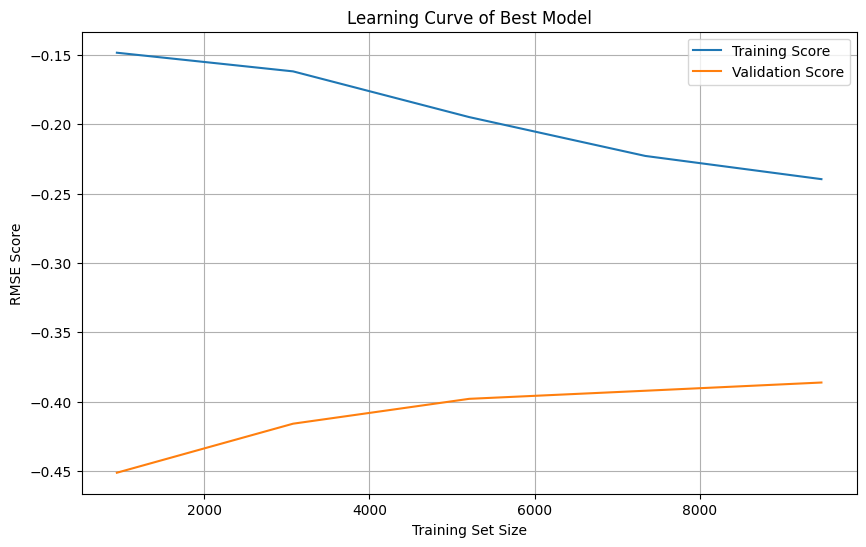

In [66]:
train_sizes, train_scores, val_scores = learning_curve(
    estimator=pipeTuned,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training Score")
plt.plot(train_sizes, val_mean, label="Validation Score")
plt.title("Learning Curve of Best Model")
plt.xlabel("Training Set Size")
plt.ylabel("RMSE Score")
plt.legend()
plt.grid()
plt.show()

- Overall, **model is decently generalized**. Validation score steadily increasing while training score decreasing.
- Model would benefit from **larger training data**. Our data is already split 80/20, so to increase generalization, **model needs more data**.

## **Model Evaluation**

In [67]:
y_pred_grad_tuned = pipeTuned.predict(X_test)

### **Residual Analysis**

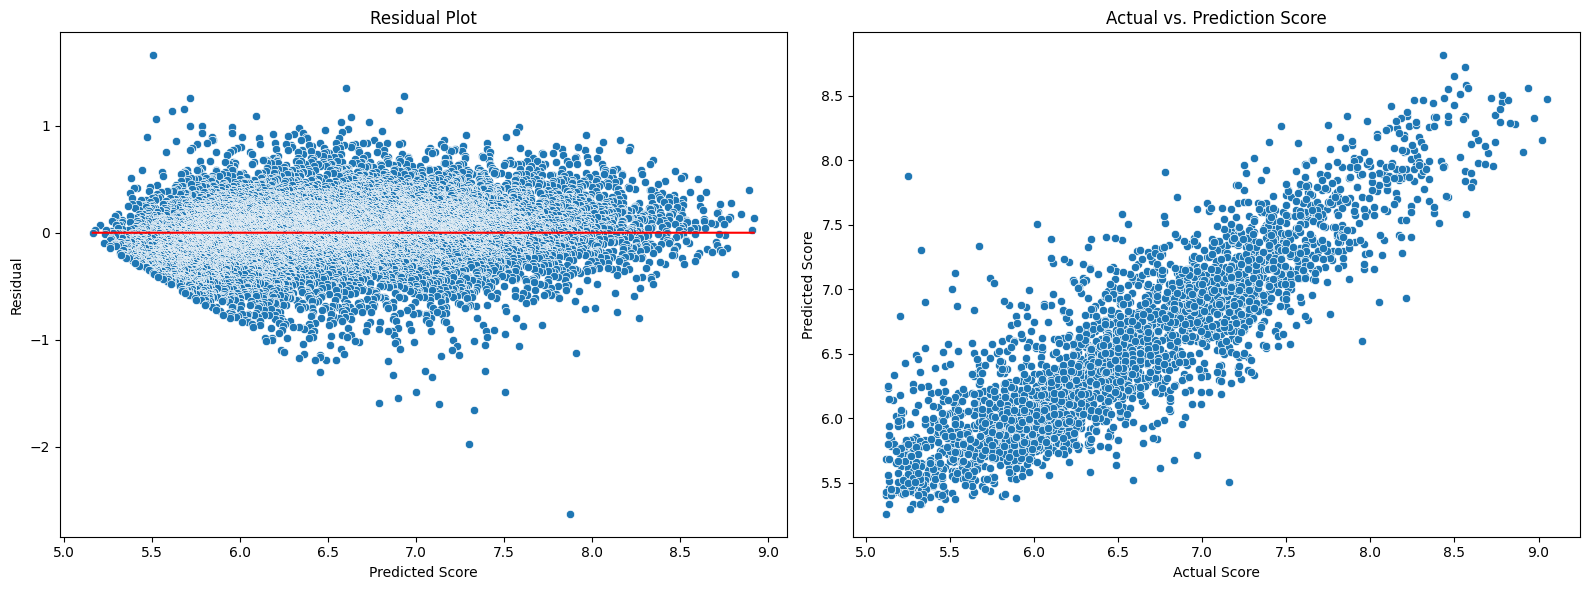

In [68]:
# Residual plot
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
sns.scatterplot(data=df_result, x='yPred', y='residual').set(title='Residual Plot', xlabel='Predicted Score', ylabel='Residual')
sns.lineplot(data=df_result, x='yPred', y=0, color='r')

plt.subplot(1,2,2)
sns.scatterplot(x=y_test, y=y_pred_grad_tuned).set(title='Actual vs. Prediction Score', xlabel='Actual Score', ylabel='Predicted Score')
plt.tight_layout()

**Insights:**
- Model is able to make accurate predictions from score ~5-9, which is the common/average range of user scores
- Some funneling can be seen from score 5.2-6.5. Most likely because most scores are distributed more around score 6-8, making the model harder to generalize the lower scores.

**Overall model is accurate and is able to consistently predict user scores.**

#### **Model Limitation**
Scope limitation: Model is highly accurate for predicting mid-to-top-rated anime, but cannot accurately generalize to low-rated shows because the dataset used is of the highest ranked ones. For more prediction range, also add lower-rated anime data to the dataset.

#### **Interpretable Model (SHAP)**
Use Shapley Value of Explanation to interpret the most significant features in our data.

In [104]:
mlb = pipeTuned.named_steps['preprocessor'].named_transformers_['genre'].named_steps['mlb'].mlb


In [ ]:
preprocessor = pipeTuned.named_steps['preprocessor']
X_train_encoded = preprocessor.transform(X_train)

feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    if transformer == 'drop':
        continue
    elif transformer == 'passthrough':
        feature_names.extend(cols)
    else:
        # ambil dari pipeline
        if hasattr(transformer, 'steps'):
            last_step = transformer.steps[-1][1]
        else:
            last_step = transformer

        # MultiLabelBinarizerTransformer
        if isinstance(last_step, MultiLabelBinarizerTransformer):
            mlb = last_step.mlb
            feature_names.extend([f"{cols[0]}_{cls}" for cls in mlb.classes_])

        # BinaryEncoder
        elif hasattr(last_step, 'get_feature_names_out'):
            feature_names.extend(last_step.get_feature_names_out(cols))
        else:
            n_out = last_step.transform(np.zeros((1, len(cols)))).shape[1]
            feature_names.extend([f"{cols[0]}_{i}" for i in range(n_out)])

# cek jumlah kolom
assert X_train_encoded.shape[1] == len(feature_names), f"{X_train_encoded.shape[1]} != {len(feature_names)}"


X_train_df = pd.DataFrame(X_train_encoded, columns=feature_names)


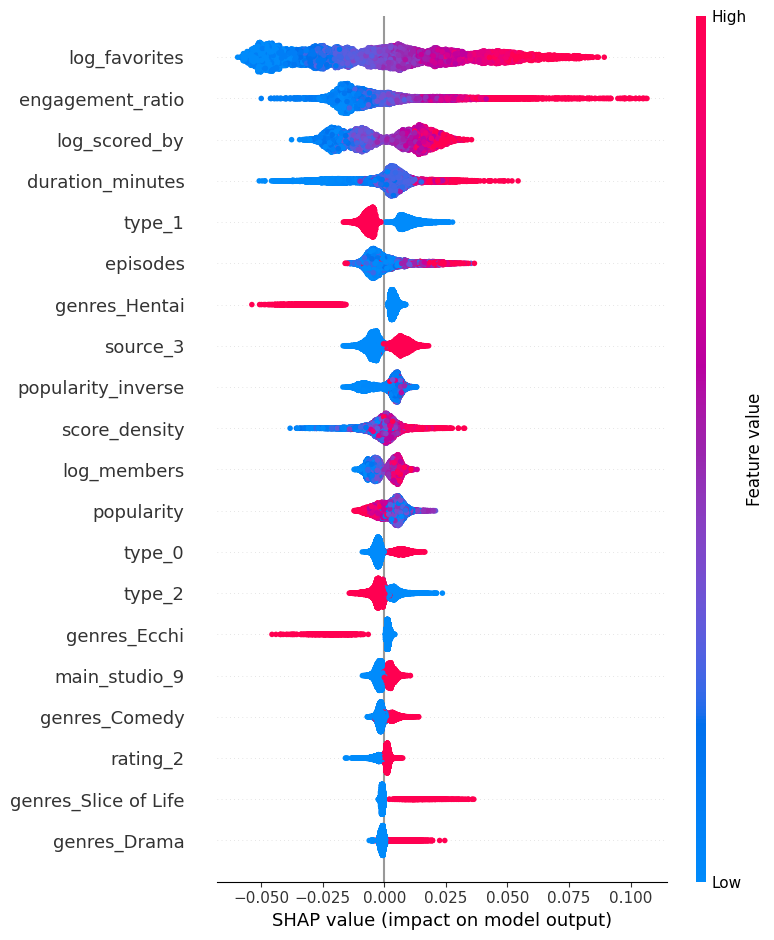

In [109]:
model_final = pipeTuned.named_steps['model'].regressor_

explainer = shap.TreeExplainer(model_final)
shap_values = explainer.shap_values(X_train_df)

# summary plot
shap.summary_plot(shap_values, X_train_df, feature_names=feature_names)


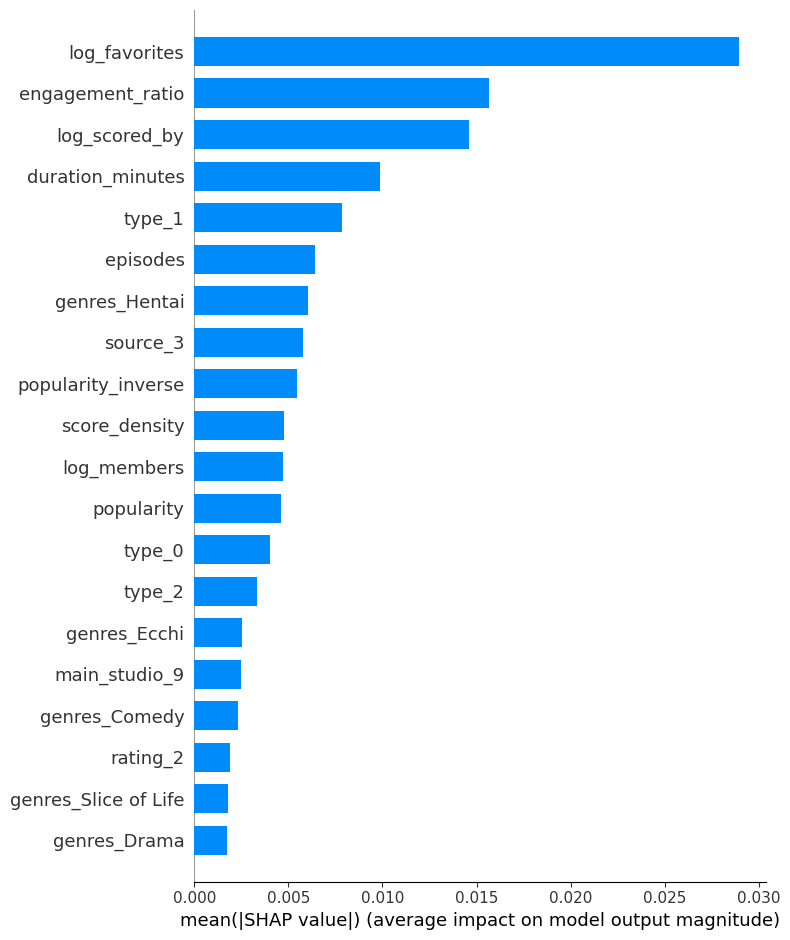

In [110]:
# bar plot
shap.summary_plot(shap_values, X_train_df, feature_names=feature_names, plot_type="bar")

In [ ]:
#TOP 10 FEATURES
shap_df = pd.DataFrame({
    'feature': feature_names,
    'mean absolute shap': np.abs(shap_values).mean(axis=0)
}).sort_values(by='mean absolute shap', ascending=False)

print(shap_df.head(10))

               feature  mean absolute shap
3        log_favorites            0.028920
6     engagement_ratio            0.015644
4        log_scored_by            0.014596
8     duration_minutes            0.009863
10              type_1            0.007850
0             episodes            0.006399
43       genres_Hentai            0.006062
15            source_3            0.005788
2   popularity_inverse            0.005466
7        score_density            0.004748


#### **Insights**
- Based on the SHAP graphs above, shows with higher scores will have more users adding it to their "Favorites" list. This is reflected by the top 2 features being log_favorites and engagement_ratio followed by log_scored_by and duration_minutes.
- **Users usually "favorite" a show only if they greatly enjoy it**. If they just liked it, they probably would just add it to their list (member) or rate it (scored_by).
- Duration contributes to the score because the typical anime duration (22-25 minutes) most likely would have more stable scores because they are the majority.
- Both higher and lower episode count result to higher score. Though this could be skewed because of the presence of one-off shows (hentai, ecchi, etc), and OVA's that are listed under a different name from the main show.
- **"Hentai" and "ecchi" are the highest rated genres**. They skewed the prediction into higher scores because they are one-off shows that creates a lot of listing in the dataset compared to typical anime shows (one listing but multiple episodes). The other higest rated genres are **comedy, slice of life, and drama**.

## **Conclusions & Recommendation**

### **Conclusions**
1. Model successfully predicts anime scores with high accuracy and performance **(RMSE 0.375, and MAPE 4.37%)**. 
2. Model showed that audience engagement metrics **(favorites, engagement ratio, and scored_by)** are the most influential indicators of how highly an anime is rated. Content-related factors **(duration, episode count, and specific genres)** also play a meaningful role but are more susceptible to dataset bias.

The results indicate that early audience interaction signals combined with basic anime metadata are powerful predictors of score.

### **Recommendations**

#### For Stakeholders:
- Monitor early engagement metrics **(favorites, scored_by, members)** on MyAnimeList as indicators on how an anime will perform. Engagment metrics are great indicators of audience sentiment.
- Use model to prioritize marketing budget on possible hit titles to maximize return.

#### For Data team:
- Collect more lower rated shows to increase model range.
- Perform imbalance treatment on inflated genre distributions coming from hentai/ecchi one-off titles.
- Add Natural Language Processing to interpret show synopsis and enhance predictive power from content.




## **Save Model**

### **Pickle**

In [ ]:
pickle.dump(pipeTuned, open("Anime_Score_model.sav", 'wb'))
print("Model saved.")

Model saved.


### **Load and Try Model**

In [ ]:
loadedModel = pickle.load(open('Anime_Score_model.sav', 'rb'))

# Tes prediksi
tesMod = loadedModel.predict(X)
tesMod.round(2)

array([8.89, 8.6 , 8.79, ..., 5.75, 5.4 , 5.33])

### **Check top 5**

In [ ]:
print(tesMod[:5].round(2))

[8.89 8.6  8.79 8.47 8.52]


In [ ]:
y.head()

0    9.29
1    9.10
2    9.07
3    9.05
4    9.05
Name: score, dtype: float64